In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
gr_mu = train.groupby('target').max().iloc[:, 1 :]
gr_mu

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
target,,,,,,,,,,,,,,,,,,,,,
0,68.876142,37.019238,103.986506,102.015561,66.062643,34.923040,120.046277,125.160611,74.101715,40.926462,...,121.959404,127.161055,54.052330,59.105536,101.058302,111.137925,35.895666,34.014883,99.927481,104.959621
1,15.861128,13.938814,88.150945,36.116640,17.006721,15.847735,75.077788,34.076014,23.137508,17.100593,...,80.164241,30.106271,16.012056,18.013143,123.179253,40.895819,14.966109,24.037756,68.033070,39.033988
2,47.012780,17.995209,127.124171,60.051620,89.059852,25.987871,98.887340,64.056338,63.818174,24.969617,...,102.142076,61.015064,58.113657,21.987083,76.933228,66.072924,54.098746,22.080906,105.914283,52.898395
3,21.058887,39.913391,113.943025,43.085918,18.342244,21.934264,118.906663,70.106275,30.896496,47.030119,...,121.877290,56.972700,13.025299,35.952587,121.897169,38.919592,35.027094,35.896503,125.974107,65.007579


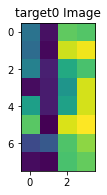

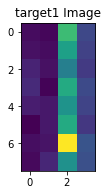

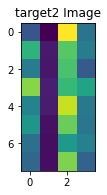

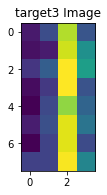

In [ ]:
for i in range(1, 5) :
  plt.figure(figsize = (6, 6))
  plt.subplot(2, 2, i)
  plt.imshow(np.array(gr_mu.iloc[i - 1]).reshape(8, 4)) 
  plt.title(f'target{i - 1} Image')

In [23]:
X = train.drop(['id', 'target'], axis = 1)
target = test.iloc[:, 1:]

In [24]:
ss = StandardScaler()

In [25]:
X = ss.fit_transform(X)
target = ss.transform(target)

In [26]:
ohe = OneHotEncoder(sparse = False)

In [27]:
y = ohe.fit_transform(train[['target']])

In [9]:
X = np.array(X).reshape(-1, 8, 4, 1)
target = np.array(target).reshape(-1, 8, 4, 1)

In [10]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
!pip install -q -U tensorflow-addons
from tensorflow_addons.optimizers import RectifiedAdam, SGDW

     |████████████████████████████████| 1.1 MB 3.8 MB/s 


In [11]:
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

In [12]:
es = EarlyStopping(monitor = 'val_acc', patience = 15, mode = 'max', verbose = 0)
reLR = ReduceLROnPlateau(patience = 5,verbose = 0, factor = 0.9)

In [15]:
cnn_acc = []
cnn_pred = np.zeros((target.shape[0], 4))
for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### CNN 모델
    cnn = Sequential()
    cnn.add(Conv2D(16, (1, 1), padding = "same", activation = 'swish', input_shape = (8, 4, 1)))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (2, 2), padding = "same", activation = 'swish'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (1, 1), padding = "same", activation = 'swish'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (3, 3), padding = "same", activation = 'swish'))
    cnn.add(BatchNormalization())
    cnn.add(GlobalAveragePooling2D())
    cnn.add(Dense(8, activation = 'swish'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(4, activation = 'softmax'))

    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'max', verbose = 0)
    
    ### 모델 compile
    cnn.compile(optimizer = Adam(learning_rate = 0.02), loss = 'binary_crossentropy', metrics = ['acc'])

    history = cnn.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 16, callbacks = [es, mc, reLR], verbose = 0)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f'{i + 1} Fold ACC of CNN = {fold_cnn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(target) / skf.n_splits
    cnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of CNN = 0.8717948717948718

2 Fold Training.....
2 Fold ACC of CNN = 0.8760683760683761

3 Fold Training.....
3 Fold ACC of CNN = 0.9188034188034188

4 Fold Training.....
4 Fold ACC of CNN = 0.8888888888888888

5 Fold Training.....
5 Fold ACC of CNN = 0.8931623931623932

6 Fold Training.....
6 Fold ACC of CNN = 0.8669527896995708

7 Fold Training.....
7 Fold ACC of CNN = 0.8927038626609443

8 Fold Training.....
8 Fold ACC of CNN = 0.8626609442060086

9 Fold Training.....
9 Fold ACC of CNN = 0.8798283261802575

10 Fold Training.....
10 Fold ACC of CNN = 0.8927038626609443



In [16]:
np.mean(cnn_acc) # 89445

0.8843567734125675

In [ ]:
cnn.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_176 (Conv2D)         (None, 8, 4, 16)          32        
                                                                 
 batch_normalization_176 (Ba  (None, 8, 4, 16)         64        
 tchNormalization)                                               
                                                                 
 conv2d_177 (Conv2D)         (None, 8, 4, 16)          1040      
                                                                 
 batch_normalization_177 (Ba  (None, 8, 4, 16)         64        
 tchNormalization)                                               
                                                                 
 conv2d_178 (Conv2D)         (None, 8, 4, 32)          544       
                                                                 
 batch_normalization_178 (Ba  (None, 8, 4, 32)       

### Record

In [46]:
submission['target'] = np.argmax((cnn_pred + cn1n_pred) / 2, axis = 1)

In [48]:
submission.to_csv('0311.csv', index = False)

In [47]:
submission.target.value_counts()

1    2508
2    2386
0    2294
3    2155
Name: target, dtype: int64